Try to reconstruct a 'clean' list of orientations in the peaks which are already cleaned to only use rings for Nickel

In [13]:
import sys, os, shutil
import time
import numpy as np, pylab as plt, h5py, numba
from base import get_yo_bins
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.transform import iradon, radon
import scipy.ndimage as ndi
from ImageD11.grain import grain, read_grain_file
from ImageD11 import sym_u, unitcell
from ImageD11 import sparseframe, cImageD11, columnfile, transform
from ImageD11.indexing import indexer
import ImageD11.indexing
import fast_histogram
import matplotlib

%matplotlib inline

In [16]:
##
### Edit input filenames here
### pksname: output of segmentation/peak-search in the previous script. Usually ends with "_pks.h5"
### parfile: target cell and detector geometry. Can be refined using the ImageD11 GUI
##
#pksname = '/data/visitor/hc4778/id15a/20220705/processed/test/BFO_merged_filtered.h5.new'
#parfile = '/data/visitor/hc4778/id15a/20220705/processed/test/BFO_edit.par'

pksname = '/data/visitor/hc4778/id15a/20220705/processed/test2/BFO_merged_pks.h5_nb.flt.new'
parfile = '/data/visitor/hc4778/id15a/20220705/processed/test2/BFO_edit.par'

#-- output files
#grainsname = '/data/visitor/hc4778/id15a/20220705/processed/test/BFO_merged_gui.ubi.map' # the grains file should be generated using makemap.py
#mapname = '/data/visitor/hc4778/id15a/20220705/processed/test/BFO_merged_gui.ubi.map2'

grainsname = '/data/visitor/hc4778/id15a/20220705/processed/test2/BFO_merged_pks.h5_nb.flt.ubinew' # the grains file should be generated using makemap.py
mapname = '/data/visitor/hc4778/id15a/20220705/processed/test2/BFO_merged_pks.h5_nb.flt.ubi.mapped'

In [3]:
#-- copy the peaks and grains into the mapfile
"""
if os.path.exists( mapname ):
    raise Exception( mapname + ' already exists')
else:
    shutil.copyfile( pksname, mapname )

grains = read_grain_file( grainsname )
initial_ubi = np.array( [g.ubi for g in grains] )
print(initial_ubi.shape, initial_ubi.dtype)

with h5py.File( mapname, 'a' ) as hmap:
    # this would fix the order, only do it later
    gr = hmap.require_group('grains')
    gr.attrs['ImageD11_type'] = 'grains'
    iu = gr.require_dataset('initial_ubi', shape=initial_ubi.shape, dtype=initial_ubi.dtype)
    iu[:] = initial_ubi
"""

"\nif os.path.exists( mapname ):\n    raise Exception( mapname + ' already exists')\nelse:\n    shutil.copyfile( pksname, mapname )\n\ngrains = read_grain_file( grainsname )\ninitial_ubi = np.array( [g.ubi for g in grains] )\nprint(initial_ubi.shape, initial_ubi.dtype)\n\nwith h5py.File( mapname, 'a' ) as hmap:\n    # this would fix the order, only do it later\n    gr = hmap.require_group('grains')\n    gr.attrs['ImageD11_type'] = 'grains'\n    iu = gr.require_dataset('initial_ubi', shape=initial_ubi.shape, dtype=initial_ubi.dtype)\n    iu[:] = initial_ubi\n"

In [14]:
#colf = columnfile.colfile_from_hdf( pksname )
colf = columnfile.columnfile( pksname )
colf.parameters.loadparameters(parfile)
colf.updateGeometry()

In [15]:
ybins, ycens, obins, ocens = get_yo_bins(colf, ystep=0.0005, ostep=0.1, show=True)
ystep = 0.0005
omegastep = 0.1

dtys: [-0.08225 -0.08175 -0.08125] ... [0.08075 0.08125 0.08175]
ybins: [-0.08225 -0.08175 -0.08125] ... [0.08075 0.08125 0.08175]
ycens: [-0.082  -0.0815 -0.081 ] ... [0.0805 0.081  0.0815]
omegas: [178.5398, 178.5399, 178.6394] ... [528.1015, 528.1016, 528.1017]
obins: [178.4898 178.5898 178.6898] ... [527.8898 527.9898 528.0898]
ocens: [178.5398 178.6398 178.7398] ... [527.8398 527.9398 528.0398]


In [5]:
# quick look at sinogram
if False:
    sino= fast_histogram.histogram2d( colf.dty, 
                                      colf.omega,
                                      weights = np.log(np.exp(1)+colf.sum_intensity), 
                                      range = [[ybins[0],ybins[-1]],
                                               [obins[0], obins[-1]]],
                                      bins = (len(ybins)-1, len(obins)-1) )

    plt.figure()
    plt.pcolormesh( obins, ybins, sino, norm=plt.matplotlib.colors.LogNorm() )
    plt.ylabel('dty')
    plt.xlabel('omega')

In [6]:
if False:
    axis = 'omega'
    #axis = 'dty'
    plt.close('all')
    fig, ax = plt.subplots(1,1, figsize=(9,5))
    pl = ax.scatter(colf.ds, colf.sum_intensity, c=getattr(colf,axis), cmap='Spectral', alpha=0.5, marker='.')
    ax.semilogy()
    plt.colorbar(pl, ax=ax, label=axis)

In [7]:
if False:
    uc = unitcell.unitcell_from_parameters(colf.parameters)
    uc.makerings(colf.ds.max())

    sel = np.zeros( colf.nrows, np.bool )
    for ds in uc.ringds:
        sel |= ((abs(colf.ds - ds) / ds ) < 1e-2)
    plt.figure()
    plt.plot(colf.ds, colf.sum_intensity, ",")
    plt.plot(colf.ds[sel], colf.sum_intensity[sel], ",")
    plt.semilogy()

(2, 12)


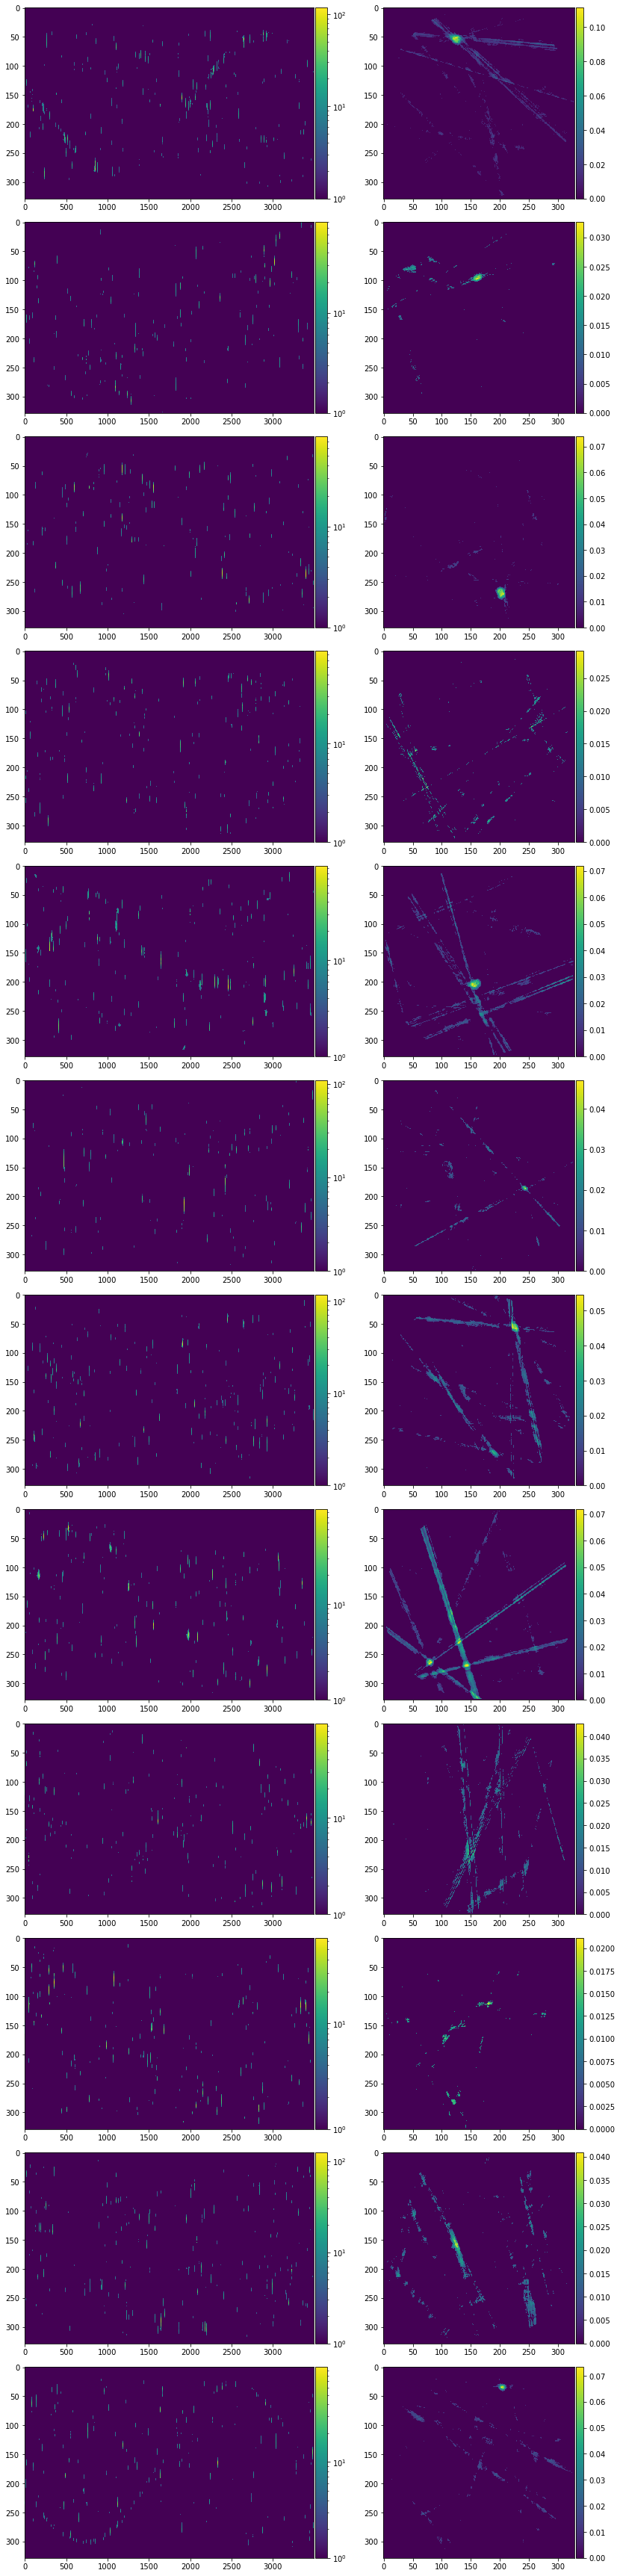

In [18]:
# assigning the peaks to the grains
# give the peak to the best fitting grain that is within 0.075

# This only uses orientation. We could also be using:
#   - spatial position in sample
#   - intensity
grains = read_grain_file( grainsname )
nrows = len(grains[:12])
fig, axes = plt.subplots(nrows,2, figsize=(12,4*nrows))
#axes = np.ravel(axes)
print(axes.T.shape)
ax = axes.T[0]
bx = axes.T[1]
for ii in range(len(grains))[:12]:
    outarray = np.zeros((len(ybins), len(obins)))
    intensities = colf.sum_intensity[colf.labels==ii]
    iomega = np.round((colf.omega[colf.labels==ii]-min(colf.omega))/omegastep, 0).astype(np.uint32) 
    #print('iomegas:', iomega[:3], iomega[-3:])
    idty = np.round((colf.dty[colf.labels==ii]-min(colf.dty))/ystep, 0).astype(np.uint32) 
    #print('idtys:', idty[:3], idty[-3:])
    outarray[idty,iomega] = intensities  
    pl = ax[ii].imshow(outarray+1, interpolation='none', aspect='auto', norm=matplotlib.colors.LogNorm())
    fig.colorbar(pl, cax=make_axes_locatable(ax[ii]).append_axes("right", size="4%", pad=0.03))
    angles = np.arange(outarray.shape[1])*omegastep
    #print('angles.shape=', angles.shape, 'sinogram.shape=', outarray.shape)
    recon = iradon(outarray, angles)
    recon = np.where((recon<0.01), 0, recon)
    pl = bx[ii].imshow(recon, interpolation='none')
    fig.colorbar(pl, cax=make_axes_locatable(bx[ii]).append_axes("right", size="4%", pad=0.03))
fig.tight_layout()


